In [1]:
import os
from pathlib import Path
import sys
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# loading python packages and files from repo root
if Path(os.getcwd()).name != "SSL4EO_base":
    os.chdir("..")

from main import METHODS
from data import constants
from data.constants import MMEARTH_DIR, input_size
from data.mmearth_dataset import MMEarthDataset, create_MMEearth_args, get_mmearth_dataloaders

/work/project/cenv/ssl4eo/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Init Model

In [28]:
# load model from checkpoint
method = "barlowtwins"
model_path = "/work/data/weights/barlowtwins/50epochs.ckpt" # replace with your own path to data

In [29]:
model_ckpt = torch.load(model_path, map_location="cpu") # no gpu required for running small samples

In [30]:
model_ckpt["hyper_parameters"]

{'backbone': 'default',
 'batch_size_per_device': 512,
 'in_channels': 12,
 'num_classes': 14,
 'has_online_classifier': True,
 'last_backbone_channel': None,
 'method': 'BarlowTwins'}

In [31]:
# intialize model from checkpoint hyper parameters
hparams = model_ckpt["hyper_parameters"]
model = METHODS[method]["model"](
    backbone=hparams["backbone"], 
    batch_size_per_device=hparams["batch_size_per_device"], 
    in_channels=hparams["in_channels"], 
    num_classes=hparams["num_classes"], 
    has_online_classifier=hparams["has_online_classifier"], 
    last_backbone_channel=hparams["last_backbone_channel"], 
    train_transform=METHODS[method]["transform"]
)

Using default backbone: resnet50


In [32]:
model.load_state_dict(model_ckpt["state_dict"])

<All keys matched successfully>

## Init Dataset

In [33]:
# initialize dataset
modalities = constants.INP_MODALITIES
split = "train"
args = create_MMEearth_args(MMEARTH_DIR, modalities, {"biome": constants.MODALITIES_FULL["biome"]})

dataset = MMEarthDataset(args, split=split)

## Retrieve Representation

In [34]:
num_samples = 1000

# choosing a random sample and saving biome and sentinel 2
s2 = []
biome = []
for idx in range(num_samples):
    data = dataset[idx]
    s2.append(torch.from_numpy(data["sentinel2"]))
    biome.append(data["biome"])

# stack to shape: b, c, h, w
s2 = torch.stack(s2, 0)

# concatentate to shape: b
biome = np.stack(biome, 0)

In [35]:
s2.shape

torch.Size([1000, 12, 128, 128])

In [36]:
biome.shape

(1000,)

In [37]:
# retrieve learned representation z
with torch.no_grad():
    model.eval()
    z = model(s2).flatten(start_dim=1)

In [38]:
z.shape

torch.Size([1000, 2048])

## Feature Covariance

In [39]:
from lightly.loss.vicreg_loss import covariance_loss, variance_loss

In [40]:
covariance_loss(z)

tensor(1.3140)

In [41]:
variance_loss(z)

tensor(0.4955)

## PCA

In [42]:
from sklearn.decomposition import PCA

In [43]:
n_components = 100
pca = PCA(n_components)

In [44]:
transformed_z = pca.fit_transform(z.numpy())

In [45]:
cmap = sns.color_palette("Set2", np.unique(biome).shape[0], as_cmap=True)

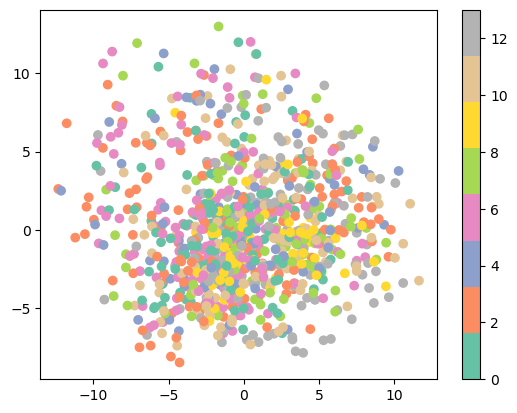

In [46]:
# plot first 2 principle components and use biome to color samples)
plt.scatter(transformed_z[:, 0], transformed_z[:, 1], c=biome, cmap=cmap)
plt.colorbar()

<BarContainer object of 100 artists>

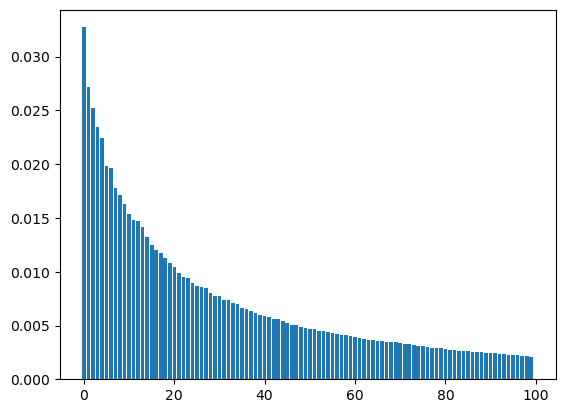

In [47]:
plt.bar(range(n_components), pca.explained_variance_ratio_)

## UMAP

In [48]:
from umap import UMAP

In [49]:
umap = UMAP()

In [50]:
transformed_z = umap.fit_transform(z)

In [51]:
cmap = sns.color_palette("Set2", np.unique(biome).shape[0], as_cmap=True)

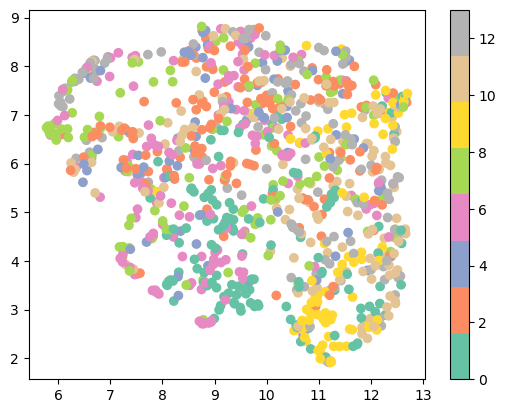

In [52]:
# plot first 2 principle components and use biome to color samples)
plt.scatter(transformed_z[:, 0], transformed_z[:, 1], c=biome, cmap=cmap)
plt.colorbar()

In [77]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


def linear_probe(embeddings, labels):
    
    X=list(embeddings)
    y=list(labels) 
    
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)  
    
    model = LogisticRegression()
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    
    #precision = precision_score(y_test, y_pred, average='weighted')  # Adjust 'average' parameter as needed
    #recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    return f1

In [78]:
linear_probe(z,biome)

0.3632580373518014

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)


plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=False, cmap='viridis')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
